# A/B Testing - Data Science Project

## Import Libraries and Data

In [43]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 16}

df = pd.read_csv('ab_data.csv')

In [2]:
# Take a look at the data
df

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


## Data Wrangling

In [7]:
# Checking to see if there are any users in control that saw new page and users in treatment that saw old page
df.groupby(['group','landing_page']).count()

user_id  timestamp  converted
group     landing_page                               
control   new_page         1928       1928       1928
          old_page       145274     145274     145274
treatment new_page       145311     145311     145311
          old_page         1965       1965       1965

In [11]:
# There are control users that saw the new page, and treatment users that saw the old page
# So, I decided to remove those users from the data set
df_cleaned = df.loc[(df['group'] == 'control') & (df['landing_page'] == 'old_page') | (df['group'] == 'treatment') & (df['landing_page'] == 'new_page')]

df_cleaned.groupby(['group','landing_page']).count()

,,user_id,timestamp,converted
group,landing_page,,,
control,old_page,145274,145274,145274
treatment,new_page,145311,145311,145311


In [23]:
# Checking for duplicate values in user_id
df_cleaned['user_id'].duplicated().sum()

1

In [26]:
# Finding user_id duplicate
df_cleaned[df_cleaned.duplicated(['user_id'],keep=False)]['user_id']

1899    773192
2893    773192
Name: user_id, dtype: int64

In [27]:
df[df['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [28]:
# This user saw the new page twice and did not converted
# For the simplicity of the experiment, let's restrict it to each user's first decision only
# Let's eliminate the second instance for this user
df_cleaned = df_cleaned.drop_duplicates(subset='user_id', keep='first')

## Exploratory Data Analysis

group      landing_page  converted
control    old_page      0            127785
                         1             17489
treatment  new_page      0            128046
                         1             17264
dtype: int64


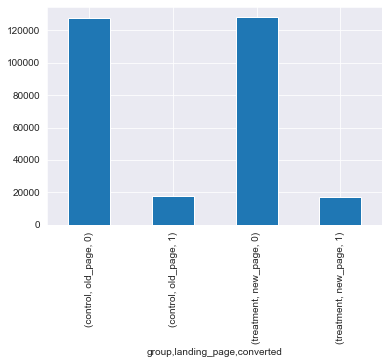

In [30]:
# Once data is cleaned, let's visualize the data with a bar chart to have a better understanding of it
groups = df_cleaned.groupby(['group','landing_page','converted']).size()
print(groups)
groups.plot.bar()

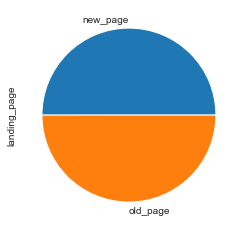

In [32]:
# As we can see, it seems that both landing pages have very similar conversion rates (aproximately 1/7)
# Now let's see the proportion between the number of users for each landing page using a pie chart
df_cleaned['landing_page'].value_counts().plot.pie()

## Data Preparation

### Re-arrange Data into 2x2 for Chi-squared

In [34]:
# 1) Split groups into two separated data frames
a = df_cleaned[df_cleaned['group'] == 'control']
b = df_cleaned[df_cleaned['group'] == 'treatment']

In [41]:
# 2) A-click, A-noclick, B-click, B-noclick
a_click = a.converted.sum()
a_noclick = a.converted.size - a.converted.sum()
b_click = b.converted.sum()
b_noclick = b.converted.size - b.converted.sum()

In [42]:
# 3) Creat a numpy array
T = np.array([[a_click, a_noclick],[b_click, b_noclick]])

## Chi-Squared Test

In [53]:
# Now that our data is in proper format we can do the Chi-squared test using scipy
# This stpe calculates the chi-suared statistic and the p-value
print(scipy.stats.chi2_contingency(T, correction=False)[0], scipy.stats.chi2_contingency(T, correction=False)[1])

1.7185222540121272 0.18988337448194853


### Conclusion

The p-value was calculated to be 19%. Assuming a 5% level of significance, we can deduce that the p-value is greater than the alpha, and therefore, we do not reject the null hypothesis. n simple terms, there is no statistical significance in conversion between the old and new page.

### Sanity Check

In [56]:
# As a sanity check, we can calculate the conversion rates between both pages
a_CTR = a_click / (a_click + a_noclick)
b_CTR = b_click / (b_click + b_noclick)
print(a_CTR,b_CTR)

0.1203863045004612 0.11880806551510564


As we can see from the sanity check, the difference in conversion rate between old and new pages is minimal, which reassures that this was conducted properly